In [251]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
register_matplotlib_converters()
from time import time

In [252]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [253]:
data = pd.read_csv('/datc/parcel/notebooks/data/postnl/20201014_300_klanten.csv', parse_dates=[0])

In [254]:
# Set Up Filter
cust_filter = data['cust_id'] == 'klant_266'
date_filter = data['procesdag'].dt.dayofweek <= 4
data = data.where(date_filter & cust_filter).dropna()

data['procesdag']=pd.to_datetime(data['procesdag'])
data = data.set_index(data.procesdag, drop=True)

In [255]:
data=data['2016-01-01':'2020-01-01']
start_date = datetime(2016, 1, 1)
end_date = datetime(2020, 1, 1)

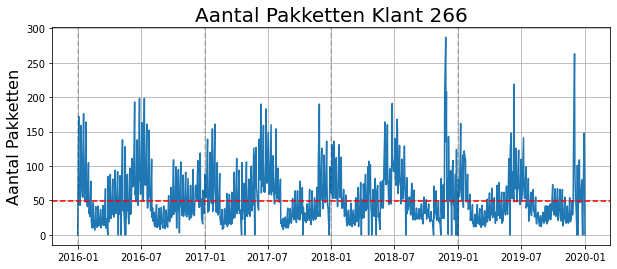

In [256]:
plt.figure(figsize=(10, 4))
plt.plot(data['aantal_pakketten'])
plt.title('Aantal Pakketten Klant 266', fontsize=20)
plt.ylabel('Aantal Pakketten', fontsize=16)
for year in range(start_date.year,end_date.year):
     plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(data['aantal_pakketten'].mean(), color='r', alpha=1, linestyle='--')
plt.grid()

In [257]:
first_diff = data['aantal_pakketten'].diff()[1:]
werkelijk = data['aantal_pakketten']

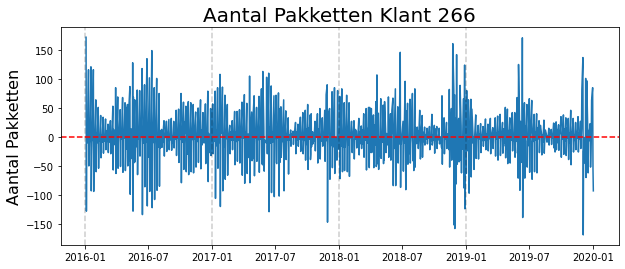

In [258]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Aantal Pakketten Klant 266', fontsize=20)
plt.ylabel('Aantal Pakketten', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(first_diff.mean(), color='r', alpha=1, linestyle='--')

In [259]:
#acf_plot = plot_acf(data['aantal_pakketten'], lags=10)

#acf_vals = acf(first_diff)
#plt.bar(range(10), acf_vals[:10])


In [260]:
#pacf_vals = pacf(first_diff)
#plt.bar(range(10),pacf_vals[:10])

In [261]:
# Train And Test
train_end = datetime(2019, 9, 1)
test_end = datetime(2019, 10, 1)

train_data = werkelijk[:train_end]
test_data = werkelijk[train_end + timedelta(days=1):test_end]

In [262]:
# Define Model
model = ARMA(train_data, order=(9,10))

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so infe

In [263]:
# Fit Model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 22.412287950515747


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [264]:
# Summary
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:       aantal_pakketten   No. Observations:                  956
Model:                    ARMA(9, 10)   Log Likelihood               -4493.162
Method:                       css-mle   S.D. of innovations             26.278
Date:                Thu, 05 Nov 2020   AIC                           9028.325
Time:                        13:22:08   BIC                           9130.442
Sample:                    01-01-2016   HQIC                          9067.221
                         - 08-30-2019                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      49.6541      4.208     11.800      0.000      41.407      57.901
ar.L1.aantal_pakketten      0.7992      0.000   7523.418      0.000       0.799       0.799


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1521: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


In [265]:
# Prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [266]:
# Predictions And Residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

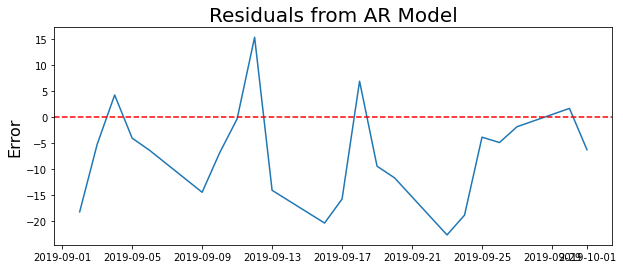

In [267]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=1)

Text(0, 0.5, 'Aantal Pakketten')

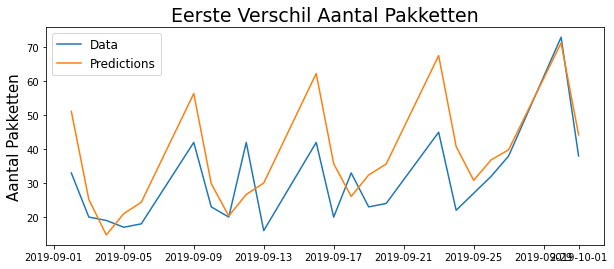

In [268]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=12)

plt.title('Eerste Verschil Aantal Pakketten', fontsize=19)
plt.ylabel('Aantal Pakketten', fontsize=15)

In [269]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 11.673184321665186
